# RandomForest on Merge

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [8]:
df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
Z = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

# Train - Test Split

In [9]:
from sklearn.model_selection import train_test_split

W = df.drop(columns=['isFraud'])
X = pd.merge(W, Z, on='TransactionID', how='left') #inner
y = df['isFraud']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_ids = X_train.pop('TransactionID')
vaild_ids = X_valid.pop('TransactionID')

cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

s = X_train[cat_cols].nunique()

threshold = 3

woe_columns = list(s[s > 3].index)
one_hot_columns = list(s[s <= 3].index)

Categorical columns (31): ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Numerical columns (401): ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55

# NA Processing # 

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class NA_Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, num_columns, cat_columns):
        self.num_columns = num_columns 
        self.cat_columns = cat_columns
        
    def fit(self, X, y):
        self.num_column_modes = X[self.num_columns].mode().T[0].to_dict()
        self.cat_column_modes = X[self.cat_columns].mode().T[0].to_dict()
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        # fill num_columns with modes
        for col in self.num_columns:
            X_transformed.fillna({col: self.num_column_modes[col]}, inplace=True)
        # fill cat_columns with modes
        for col in self.cat_columns:
            X_transformed.fillna({col: self.cat_column_modes[col]}, inplace=True)
        return X_transformed


# Custom Encoding

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self


    def transform(self, X):
        X_transformed = X.copy()

        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=False, dtype=int)
       
        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)

        for col in na_cols:
            if "woe" not in col:
                print("Error Related to Nans")
            name = col.rpartition('_')[0]

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed

# Final Custom Encoder

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalCustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns, final_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder
        self.final_columns = final_columns
        
    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self


    def transform(self, X):
        X_transformed = X.copy()

        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=False, dtype=int)
       
        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)

        for col in na_cols:
            if "woe" not in col:
                print("Error Related to Nans")
            name = col.rpartition('_')[0]
            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed[self.final_columns]

# Correlation Filtering

In [13]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X, y):
        X_corr = X.copy()
        X_corr['target'] = y
        corr_matrix = X_corr.corr().abs()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

        features_to_drop = []
        for feat1, feat2, _ in high_corr_pairs:
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                features_to_drop.append(feat1)
            else:
                features_to_drop.append(feat2)
        self.features_to_drop = list(set(features_to_drop))
        return self

    def transform(self, X):
        # Drop highly correlated features
        print(self.features_to_drop)
        return X.drop(columns=self.features_to_drop)

In [14]:
!pip install optbinning
import matplotlib.pyplot as plt
from optbinning import OptimalBinning
from optbinning.binning.binning import BinningTable

import xgboost as xgb
import shap

!pip install kds
import kds
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 62.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.

# RF Feature Importance

Processing ProductCD...
Processing card4...
Processing card6...
Processing P_emaildomain...
Processing R_emaildomain...
Processing id_30...
Processing id_31...
Processing id_33...
Processing id_34...
Processing DeviceInfo...


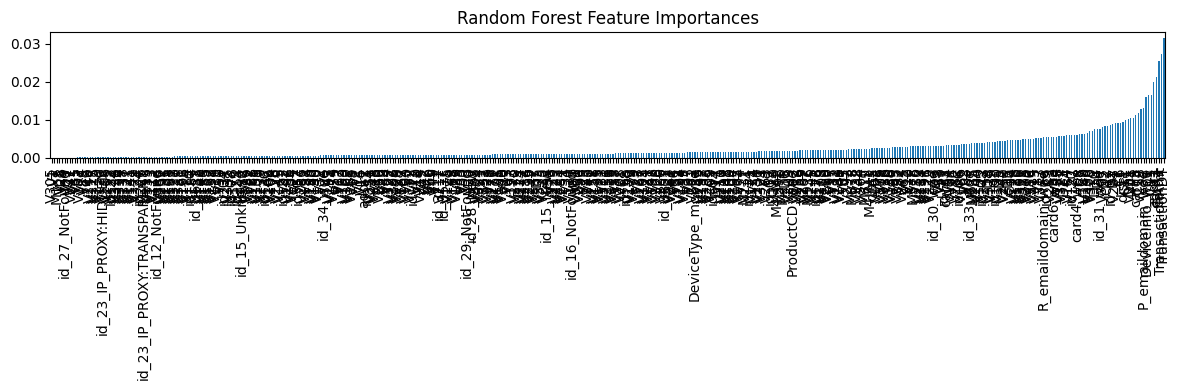

In [16]:
from sklearn.ensemble import RandomForestClassifier

X_train_t = NA_Preprocessor(num_cols, cat_cols).fit_transform(X_train, y_train)
X_train_encoded = CustomEncoder(woe_columns, one_hot_columns).fit_transform(X_train_t, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)
pd.Series(rf.feature_importances_, index=X_train_encoded.columns).sort_values().plot(kind="bar", figsize=(12, 4), title="Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [18]:
importances = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)

# Sort in descending order
importances_sorted = importances.sort_values(ascending=False)

# Cumulative sum
cumulative_importance = importances_sorted.cumsum()

# Select features that make up 95% of total importance
selected_features = cumulative_importance[cumulative_importance <= 0.95].index
selected_features

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'C13',
       'C1', 'DeviceInfo_woe', 'P_emaildomain_woe', 'V258',
       ...
       'V11', 'V49', 'V60', 'V46', 'V42', 'V69', 'V214', 'V10', 'V72',
       'id_11'],
      dtype='object', length=294)

# Pipeline

In [20]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier

# Create an imbalanced-learn pipeline
imb_pipeline = ImbPipeline(steps=[
    ('na_processor', NA_Preprocessor(num_cols, cat_cols)),
    ('encoder', FinalCustomEncoder(woe_columns, one_hot_columns, selected_features)),
    ('correlation_filter', CorrelationFilter(threshold=0.8)),
    ('scaler', StandardScaler()), 
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.2)),  # Undersampling step
    ('classifier', RandomForestClassifier(
                        n_estimators=700,        # Number of trees in the forest
                        max_depth=10,            # Maximum depth of each tree
                        max_features='sqrt',     # Number of features to consider at each split
                        bootstrap=True,          # Whether bootstrap samples are used
                        random_state=42,         # For reproducibility
                    ))
])

imb_pipeline.fit(X_train, y_train)

Processing ProductCD...
Processing card4...
Processing card6...
Processing P_emaildomain...
Processing R_emaildomain...
Processing id_30...
Processing id_31...
Processing id_33...
Processing id_34...
Processing DeviceInfo...
['V217', 'V91', 'V73', 'V60', 'C7', 'id_29_NotFound', 'V189', 'V93', 'V233', 'V153', 'V218', 'V243', 'V300', 'V321', 'V261', 'V102', 'V280', 'V279', 'V221', 'V249', 'V133', 'C4', 'C11', 'V296', 'V193', 'V230', 'V105', 'V44', 'V129', 'V11', 'V131', 'V70', 'V82', 'V202', 'V188', 'V130', 'V136', 'V242', 'C10', 'V135', 'V39', 'V178', 'V246', 'V80', 'V244', 'V316', 'V307', 'V149', 'V294', 'V170', 'V33', 'V194', 'V134', 'V275', 'V42', 'V318', 'V127', 'V100', 'V37', 'C13', 'V259', 'V186', 'V323', 'V308', 'V291', 'V306', 'V298', 'V172', 'V213', 'V219', 'V97', 'V272', 'id_17', 'V225', 'V319', 'V267', 'V79', 'V94', 'V313', 'V126', 'V66', 'V156', 'C8', 'V154', 'V212', 'V211', 'id_16_NotFound', 'id_15_New', 'C12', 'V256', 'V245', 'V265', 'V148', 'V314', 'V76', 'V266', 'V198', 

Pipeline(steps=[('na_processor',
                 NA_Preprocessor(cat_columns=['ProductCD', 'card4', 'card6',
                                              'P_emaildomain', 'R_emaildomain',
                                              'M1', 'M2', 'M3', 'M4', 'M5',
                                              'M6', 'M7', 'M8', 'M9', 'id_12',
                                              'id_15', 'id_16', 'id_23',
                                              'id_27', 'id_28', 'id_29',
                                              'id_30', 'id_31', 'id_33',
                                              'id_34', 'id_35', 'id_36',
                                              'id_37', 'id_38', 'DeviceType', ...],
                                 num_columns=['TransactionDT', 'TransactionAmt',...
                                    woe_columns=['ProductCD', 'card4', 'card6',
                                                 'P_emaildomain',
                                                 'R_emaildomain', 'id_30',
                                                 'id_31', 'id_33', 'id_34',
                                                 'DeviceInfo'])),
                ('correlation_filter', CorrelationFilter(threshold=0.8)),
                ('scaler', StandardScaler()),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=700,
                                        random_state=42))])

In [21]:
y_pred = imb_pipeline.predict(X_valid)
y_pred_proba = imb_pipeline.predict_proba(X_valid)[:, 1]

['V217', 'V91', 'V73', 'V60', 'C7', 'id_29_NotFound', 'V189', 'V93', 'V233', 'V153', 'V218', 'V243', 'V300', 'V321', 'V261', 'V102', 'V280', 'V279', 'V221', 'V249', 'V133', 'C4', 'C11', 'V296', 'V193', 'V230', 'V105', 'V44', 'V129', 'V11', 'V131', 'V70', 'V82', 'V202', 'V188', 'V130', 'V136', 'V242', 'C10', 'V135', 'V39', 'V178', 'V246', 'V80', 'V244', 'V316', 'V307', 'V149', 'V294', 'V170', 'V33', 'V194', 'V134', 'V275', 'V42', 'V318', 'V127', 'V100', 'V37', 'C13', 'V259', 'V186', 'V323', 'V308', 'V291', 'V306', 'V298', 'V172', 'V213', 'V219', 'V97', 'V272', 'id_17', 'V225', 'V319', 'V267', 'V79', 'V94', 'V313', 'V126', 'V66', 'V156', 'C8', 'V154', 'V212', 'V211', 'id_16_NotFound', 'id_15_New', 'C12', 'V256', 'V245', 'V265', 'V148', 'V314', 'V76', 'V266', 'V198', 'V192', 'V190', 'V200', 'V273', 'V61', 'V95', 'V179', 'V51', 'V216', 'V128', 'V264', 'C1', 'V137', 'V4', 'V43', 'V87', 'V101', 'V19', 'V85', 'V251', 'V204', 'V276', 'V288', 'V125', 'V215', 'V229', 'V96', 'V54', 'C14', 'V30', 

In [22]:
!pip install dagshub mlflow
import dagshub
dagshub.init(repo_owner='GLasare', repo_name='ML_Fraud_Detection', mlflow=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 63.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 84.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
  

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=39944fb5-f1f7-4495-99ba-6eb2075a04ca&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=11780470f27565be96d67fdb0af2432714dae78fbb8cb7da1481603c91d43747




Accessing as GLasare

Initialized MLflow to track repo "GLasare/ML_Fraud_Detection"

Repository GLasare/ML_Fraud_Detection initialized!

In [39]:
import mlflow
class MLFlowLogger():
    def __init__(self, experiment_name, pipeline):
        self.exp = experiment_name
        self.pipeline = pipeline

    def set(self, run_name, log_func):
        self.run = run_name
        self.log_func = log_func

    def log(self):
        mlflow.set_experiment(self.exp)
        mlflow.start_run(run_name=self.run)
        self.log_func(self.pipeline)
        mlflow.end_run()

In [27]:
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def cleaning_logger(imb_pipeline):
    na_step = imb_pipeline.named_steps['na_processor']
    mlflow.log_param("num_cols", ",".join(na_step.num_columns))
    mlflow.log_param("cat_cols", ",".join(na_step.cat_columns))
    mlflow.log_param("NA_filling_strategy", "Mode")
  
def feature_engineering_logger(imb_pipeline):
    encoder_step = imb_pipeline.named_steps['encoder']
    mlflow.log_param("woe_cols", ",".join(encoder_step.woe_columns))
    mlflow.log_param("one_hot_cols", ",".join(encoder_step.one_hot_columns))
    mlflow.log_param("scaler", "Standard Scaler")

    if isinstance(encoder_step, FinalCustomEncoder):
        mlflow.log_param("Shap Selected Features", ",".join(encoder_step.final_columns))
        

def feature_selection_logger(imb_pipeline):
    corr_filter_step = imb_pipeline.named_steps['correlation_filter']
    mlflow.log_param("corr_filter_threshold", corr_filter_step.threshold)
    mlflow.log_param("features_to_drop", ",".join(corr_filter_step.features_to_drop))
    mlflow.log_param("sampling_strategy", imb_pipeline.named_steps['undersampler'].sampling_strategy)


def cross_validation_logger(imb_pipeline):
    precision_scorer = make_scorer(precision_score)
    recall_scorer = make_scorer(recall_score)
    f1_scorer = make_scorer(f1_score)
    roc_auc_scorer = make_scorer(roc_auc_score)

    X_train_final, y_train_final = imb_pipeline[:-1].fit_resample(X_train, y_train)
    
    metrics = {
        'precision': precision_scorer,
        'recall': recall_scorer,
        'f1': f1_scorer,
        'roc_auc': roc_auc_scorer
    }

    model = imb_pipeline.named_steps['classifier']
    for metric_name, scorer in metrics.items():
        # Cross-validation using the current scorer
        scores = cross_val_score(model, X_train_final, y_train_final,
                                 scoring=scorer, cv=3, n_jobs=-1)
        
        # Log the average score and the standard deviation for each metric
        mlflow.log_metric(f"cv_{metric_name}_mean", scores.mean())
        mlflow.log_metric(f"cv_{metric_name}_std", scores.std())

        # Log individual fold scores for each metric
        for i, score in enumerate(scores):
            mlflow.log_metric(f"cv_{metric_name}_fold_{i+1}", score)
    

def training_logger(imb_pipeline):
    mlflow.log_param("model_type", "XGBoost")

    model = imb_pipeline.named_steps['classifier']
    for param_name, param_value in model.get_params().items():
        mlflow.log_param(param_name, param_value)
    
    mlflow.log_param("woe_columns_count", len(woe_columns))
    mlflow.log_param("one_hot_columns_count", len(one_hot_columns))

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='binary')
    recall = recall_score(y_valid, y_pred, average='binary')
    f1 = f1_score(y_valid, y_pred, average='binary')
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")

    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_valid, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    mlflow.log_metric("pr_auc", pr_auc)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.sklearn.log_model(imb_pipeline, "final_pipeline_model")


# Logging Cleaning, Feature Engineering, Feature Selection and Training

In [40]:
experiment_name = 'RandomForest_Exp'
mlflow_logger = MLFlowLogger(experiment_name, imb_pipeline)

🏃 View run XGBoost_Cross_Validation at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/ce5f035acd3f4b069de98e01cc7a2183
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16
🏃 View run RandomForest_Cleaning at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/5f681a554ed74518abd4557c56c05236
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16
🏃 View run RandomForest_Engineering at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/f016ee2baa5a41a6aaaec59fffbfa851
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16
🏃 View run RandomForest_Selection at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/ee430dac1d304374a18471e223f9ce8b
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16


2025/04/21 15:04:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvf4ay41h/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/21 15:04:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Training at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/b4c585b8656c4ec7844ddb915e79b24c
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16
Processing ProductCD...
Processing card4...
Processing card6...
Processing P_emaildomain...
Processing R_emaildomain...
Processing id_30...
Processing id_31...
Processing id_33...
Processing id_34...
Processing DeviceInfo...
['V217', 'V91', 'V73', 'V60', 'C7', 'id_29_NotFound', 'V189', 'V93', 'V233', 'V153', 'V218', 'V243', 'V300', 'V321', 'V261', 'V102', 'V280', 'V279', 'V221', 'V249', 'V133', 'C4', 'C11', 'V296', 'V193', 'V230', 'V105', 'V44', 'V129', 'V11', 'V131', 'V70', 'V82', 'V202', 'V188', 'V130', 'V136', 'V242', 'C10', 'V135', 'V39', 'V178', 'V246', 'V80', 'V244', 'V316', 'V307', 'V149', 'V294', 'V170', 'V33', 'V194', 'V134', 'V275', 'V42', 'V318', 'V127', 'V100', 'V37', 'C13', 'V259', 'V186', 'V323', 'V308', 'V291', 'V306', 'V298', 'V172', '

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.3.2. This might l

🏃 View run RandomForest_Cross_Validation at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16/runs/14aaec4fb0a24bf48014be36d8740280
🧪 View experiment at: https://dagshub.com/GLasare/ML_Fraud_Detection.mlflow/#/experiments/16


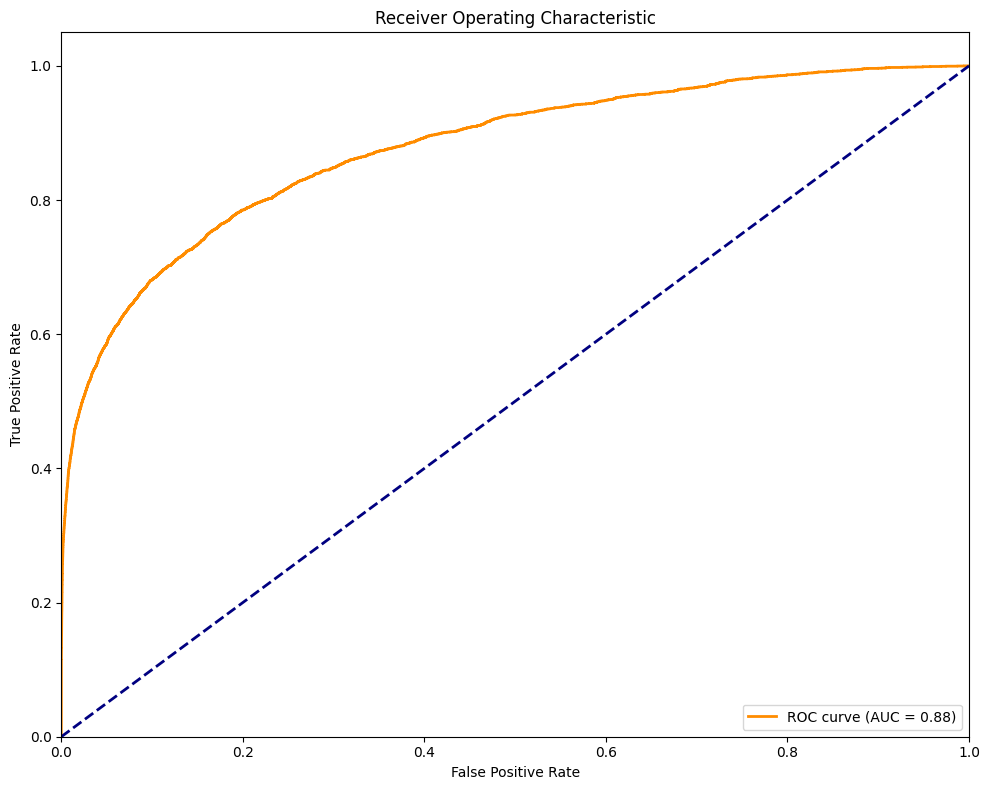

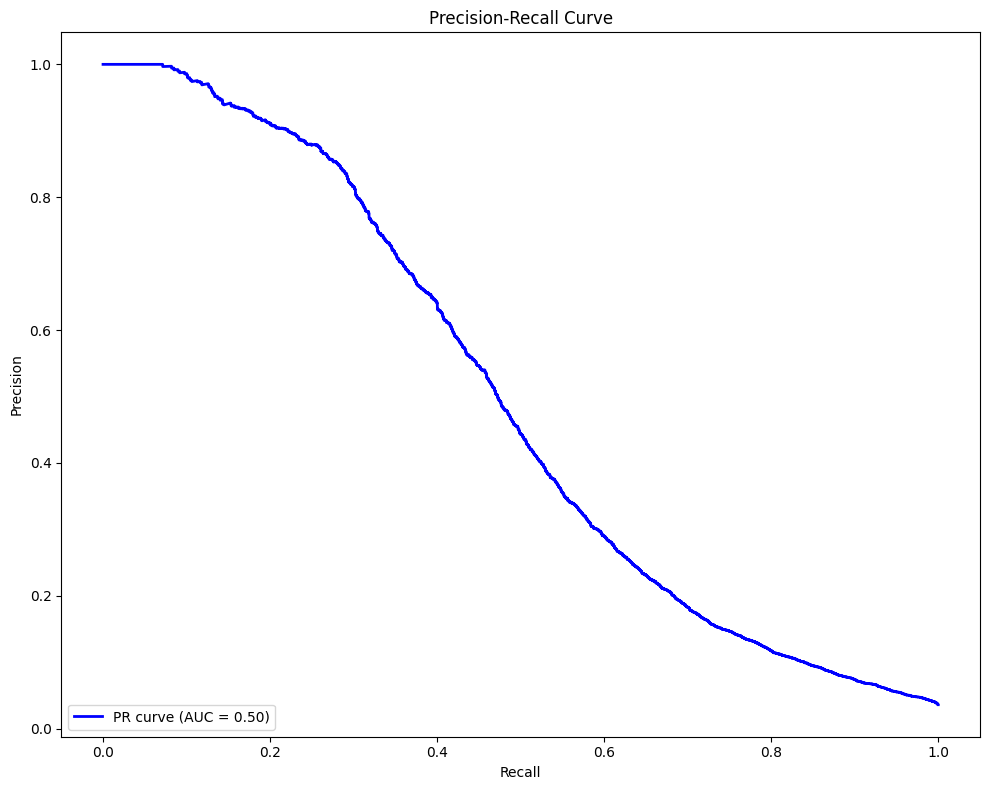

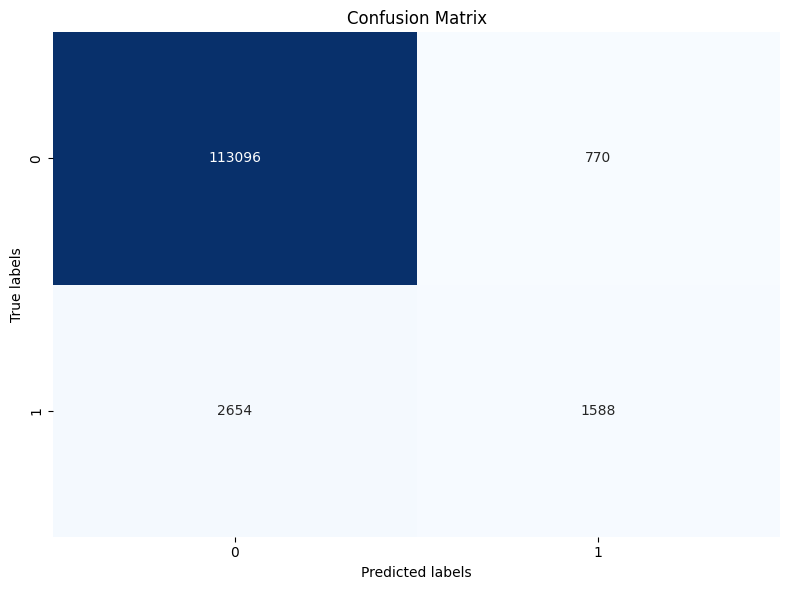

In [41]:
mlflow_logger.set("RandomForest_Cleaning", cleaning_logger)
mlflow_logger.log()

mlflow_logger.set("RandomForest_Engineering", feature_engineering_logger)
mlflow_logger.log()

mlflow_logger.set("RandomForest_Selection", feature_selection_logger)
mlflow_logger.log()

mlflow_logger.set("RandomForest_Training", training_logger)
mlflow_logger.log()

mlflow_logger.set("RandomForest_Cross_Validation", cross_validation_logger)
mlflow_logger.log()